# Logistic Regression Meta-Learner

Here we consider a logistic regression framework as a meta-learner on the output from three neural networks combined with all available categorical data. We begin with setup and imports, apologies again for the wall of imports. 

In [1]:
from pyspark.sql import SparkSession

#run me on the DS5110 kernel if running on Rivanna!

#Build spark session, unable to get more than 8 cores for the second half of the semester
#This configuration performs relatively well given that constraint. This application definitely wants more cores though. 
spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '14g') \
    .config("spark.executor.instances", "7") \
    .config('spark.executor.cores', '2') \
    .config("spark.driver.memory",'14g') \
    .config("spark.driver.maxResultSize", "6g")\
    .getOrCreate()

sc = spark.sparkContext


In [2]:
#Give me the modules and no one gets hurt
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import re
from pyspark.ml.feature import *
from pyspark.ml.classification import GBTClassifier
from spark_tensorflow_distributor import MirroredStrategyRunner
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Read in pre-featurized images
Here we read in pre-featurized images from the parquet saved in the image featurization notebook. 

In [5]:
data = spark.read.parquet("clean_features.parquet2").na.drop('any')
data.show(5)

+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|            mnet_vec|             r50_vec|            xcep_vec|
+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|ISIC_0024306|HAM_0000550|ISIC_0024306| nv|follow_up|45.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[0.24354705214500...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024387|HAM_0004156|ISIC_0024387| nv|    histo|65.0|female|lower extremity|[0.0,1.3627424240...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024397|HAM_0001501|ISIC_0024397| nv|follow_up|65.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[1.18369388580322...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024551|HAM_0002629|ISIC_0024551| nv|follow_up|50.0|  male|        abdomen|[0.0,0.0,0.0,0.0,...|[0.01115676853805...|[0.0,0.

# Define Pipeline
We one hot encode sex and location and combine it with age and the neural network derived features. 

In [19]:
#Define preprocessing pipeline

#index our response variable
label_index = StringIndexer(inputCol = 'dx', outputCol = 'indexed_dx')

#Index the two categorical variables that we have
label_sex = StringIndexer(inputCol = 'sex', outputCol = 'indexed_sex')
loc_index = StringIndexer(inputCol = 'localization', outputCol = 'indexed_loc')

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age',  'OH_sex', 'OH_loc', 'mnet_vec', 'r50_vec', 'xcep_vec'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')

#vec_index = VectorIndexer(inputCol = 'Feature_vec', outputCol = 'indexed_features', maxCategories = 8, handleInvalid = 'skip')


log_reg = LogisticRegression(featuresCol = 'Feature_vec', labelCol = 'indexed_dx', maxIter=20, regParam=0.3, \
                             elasticNetParam=0,  family="multinomial", threshold = .5, probabilityCol='probability')
pipe = Pipeline(stages = [label_index, label_sex, loc_index, OH, vec_assemb, log_reg])


# Cross Validation

We perform 5 fold cross validation and search across regularization parameter and elastic net parameter. The number of iterations is not considered for cross-validation. 

In [20]:
#Setup parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(log_reg.regParam, [0.01, .025, 0.05]) # regularization parameter
             .addGrid(log_reg.elasticNetParam, [0.0, 0.05, 0.1]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [21]:
#Setup 5 fold cross validation
cv = CrossValidator(estimator=pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx"), \
                    numFolds=5, \
                    parallelism = 4,\
                    seed = 314)

# Split training and test data

We opt for a stratified 80-20 split due to the presence of small minority classes in the problem. True random splitting risks leaving one set with too few samples. 

In [22]:
#Define Fractions for training and test split
training_frac = {'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [23]:
#Stratified sample
train = data.sampleBy('dx', training_frac, seed = 314)
#cache for performance
train.cache()

DataFrame[ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, mnet_vec: vector, r50_vec: vector, xcep_vec: vector]

In [24]:
#Define the test set, just subtract train from the remainder of the data
test = data.subtract(train)


# Fit and evaluate the model

We perform cross validation and examine performance on the training set. We look at overall metrics and specifically at melanoma as the most malignant disorder in the dataset. It is of particular interest to classify this one accurately. 

In [25]:
#Call our CV model to fit on the training set
cvModel = cv.fit(train)

In [26]:
#Evaluate performance on the validation set
results = cvModel.transform(test)

In [42]:
preds_and_labels.show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       2.0|  2.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 5 rows



In [20]:
#Subset predictions in order to map to RDD, we prefer mllibs classification evasluator
subset_results = results.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

#select only prediction and label columns
preds_and_labels = subset_results.select(['prediction','label'])
#Make an RDD for mllib 
preds_labels_rdd = preds_and_labels.rdd.map(tuple)

metrics = MulticlassMetrics(preds_labels_rdd)

print(metrics.confusionMatrix().toArray())

[[1.287e+03 4.500e+01 1.700e+01 4.000e+00 2.000e+00 0.000e+00 1.000e+00]
 [6.800e+01 1.080e+02 1.900e+01 2.000e+00 5.000e+00 0.000e+00 4.000e+00]
 [2.600e+01 2.200e+01 1.570e+02 6.000e+00 6.000e+00 0.000e+00 0.000e+00]
 [7.000e+00 6.000e+00 1.000e+01 7.400e+01 6.000e+00 2.000e+00 2.000e+00]
 [5.000e+00 6.000e+00 1.200e+01 6.000e+00 4.000e+01 0.000e+00 0.000e+00]
 [3.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.700e+01 0.000e+00]
 [4.000e+00 2.000e+00 3.000e+00 2.000e+00 0.000e+00 1.000e+00 1.100e+01]]


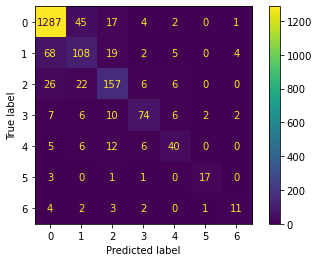

In [23]:
#ok, that's heinously ugly. It's not spark, but this looks more presentable
%matplotlib inline
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [21]:
#Define some weighted model metrics
weighted_recall =  metrics.weightedRecall
weighted_precision =  metrics.weightedPrecision
weighted_f1 = metrics.weightedFMeasure(beta = 1.0)
weighted_fpr =  metrics.weightedFalsePositiveRate
accuracy = metrics.accuracy

In [22]:
#Don't kill me, the pandas dataframe is just so it looks nicer in the notebook
values = [weighted_recall, weighted_precision, weighted_f1, weighted_fpr, accuracy]
index = ['recall', 'precision', 'F1 score', 'FPR', 'accuracy']

pd.DataFrame(values, index = index, columns = ['Metric Value'])

,Metric Value
recall,0.847000
precision,0.841357
F1 score,0.843526
FPR,0.128380
accuracy,0.847000


In [24]:
#Get Parameters for best model 
bestModel = cvModel.bestModel
reg_param = bestModel.stages[5].getRegParam()
elastic_param = bestModel.stages[5].getElasticNetParam()

values = [reg_param, elastic_param]
index = ['Regularization', 'Elastic Net']

pd.DataFrame(values, index = index, columns = ['Hyperparameter Value'])

,Hyperparameter Value
Regularization,0.025
Elastic Net,0.000


In [33]:
labels = [0.0,1.0,2.0,3.0,4.0,5.0,6.0]
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.933962,0.919286,0.949115
1,1.0,0.546835,0.571429,0.524272
2,2.0,0.720183,0.716895,0.723502
3,3.0,0.732673,0.778947,0.691589
4,4.0,0.625000,0.677966,0.579710
5,5.0,0.809524,0.850000,0.772727
6,6.0,0.536585,0.611111,0.478261


In [27]:
preds_and_probs = results.select(['indexed_dx', 'probability', 'prediction'])

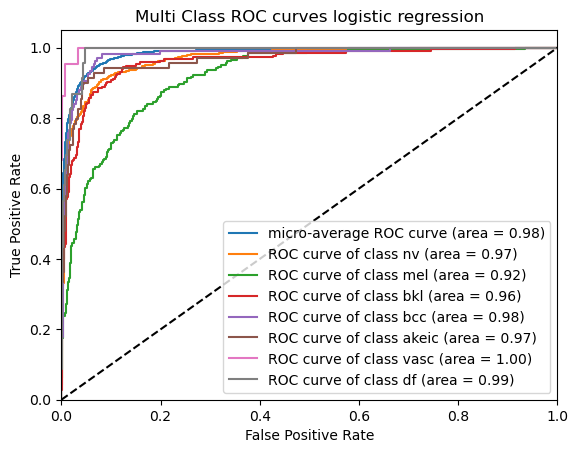

In [28]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])

n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

class_dict = {0:'nv', 1:'mel', 2: 'bkl', 3: 'bcc', 4: 'akeic', 5: 'vasc', 6: 'df'}

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC curves logistic regression')
plt.legend(loc="lower right")
plt.show()

# Model Sensitivity

Here we use a regularization parameter of .3 rather than .025. Overall accuracy decreases slightly at 1.7 percent and the change to the micro averaged ROC curve is negligible. 

In [30]:
#Fit a model with regularization .3, defau supplied in pipe
perturbed_model = pipe.fit(train)

In [31]:
#obtain predictiosn with model at this hyperparameter value
perturbed_preds = perturbed_model.transform(test)

In [83]:
#Cast labels to float
subset_results = perturbed_preds.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

# Confusion matrix

We see from the confusion matrix that we are quite biased towards predicting NV correctly. Disssapointingly, we only recall around half of melanoma. 

In [103]:
#select only prediction and label columns
preds_and_labels = subset_results.select(['prediction','label'])
#Make an RDD for mllib 
preds_labels_rdd = preds_and_labels.rdd.map(tuple)

metrics = MulticlassMetrics(preds_labels_rdd)

print(metrics.confusionMatrix().toArray())

[[1.307e+03 2.800e+01 1.700e+01 3.000e+00 0.000e+00 0.000e+00 1.000e+00]
 [8.100e+01 9.100e+01 2.500e+01 4.000e+00 4.000e+00 0.000e+00 1.000e+00]
 [4.200e+01 2.200e+01 1.440e+02 7.000e+00 2.000e+00 0.000e+00 0.000e+00]
 [1.500e+01 7.000e+00 8.000e+00 7.200e+01 3.000e+00 2.000e+00 0.000e+00]
 [9.000e+00 5.000e+00 2.000e+01 9.000e+00 2.600e+01 0.000e+00 0.000e+00]
 [6.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.400e+01 0.000e+00]
 [6.000e+00 5.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00]]


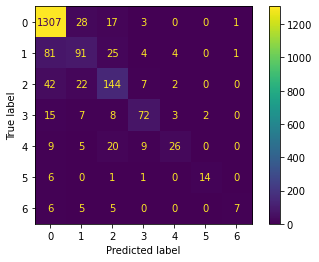

In [104]:
#ok, that's heinously ugly. It's not spark, but this looks more presentable
%matplotlib inline
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [105]:
#Define some weighted model metrics
weighted_recall =  metrics.weightedRecall
weighted_precision =  metrics.weightedPrecision
weighted_f1 = metrics.weightedFMeasure(beta = 1.0)
weighted_fpr =  metrics.weightedFalsePositiveRate
accuracy = metrics.accuracy

In [106]:
#Don't kill me, the pandas dataframe is just so it looks nicer in the notebook
values = [weighted_recall, weighted_precision, weighted_f1, weighted_fpr, accuracy]
index = ['recall', 'precision', 'F1 score', 'FPR', 'accuracy']

pd.DataFrame(values, index = index, columns = ['Metric Value'])

,Metric Value
recall,0.830500
precision,0.819129
F1 score,0.819370
FPR,0.176728
accuracy,0.830500


In [32]:
preds_and_probs = perturbed_preds.select(['indexed_dx', 'probability', 'prediction'])

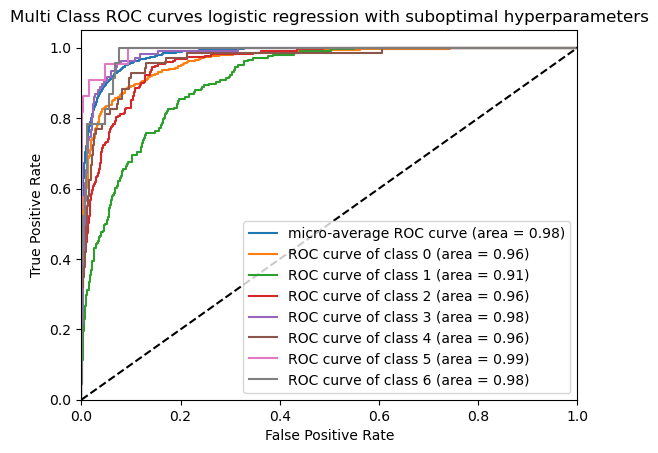

In [33]:
#From sklearn plotting ROC curves in multiclass setting
import matplotlib.pyplot as plt
y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])

n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC curves logistic regression with suboptimal hyperparameters')
plt.legend(loc="lower right")
plt.show()

# Undersampling

Here we undersample to get an even training set by sampling 80% of dermofibromas and an equal number of other classes. Undersampling hits model performance overall and does not provide a clear advantage with classifying the main class of interest: melanoma. 


In [3]:
#Define Fractions for training and test split
training_frac = {'vasc': 0.8*.8,
 'nv': 0.8 *.017,
 'mel': 0.8*.1,
 'bcc': 0.8 * .22,
 'df': 0.8 ,
 'bkl': 0.8 * .1,
 'akiec': 0.33*.8}

In [6]:
#Stratified sample
train = data.sampleBy('dx', training_frac, seed = 314)
#cache for performance
train.cache()

DataFrame[ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, mnet_vec: vector, r50_vec: vector, xcep_vec: vector]

In [7]:
test = data.subtract(train)

In [10]:
lr_model = pipe.fit(train)

In [11]:
results = lr_model.transform(test)

In [152]:
#select only prediction and label columns
preds_and_labels = results.select(['prediction','indexed_dx'])
#Make an RDD for mllib 
preds_labels_rdd = preds_and_labels.rdd.map(tuple)

metrics = MulticlassMetrics(preds_labels_rdd)

print(metrics.confusionMatrix().toArray())

[[2.760e+02 2.100e+01 4.100e+01 1.300e+01 8.000e+00 3.900e+01 1.700e+01]
 [1.000e+00 4.300e+01 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 1.800e+01 0.000e+00 0.000e+00 3.000e+00 2.000e+00]
 [9.300e+01 1.000e+01 3.900e+01 5.540e+02 5.600e+01 9.100e+01 1.590e+02]
 [2.140e+02 1.800e+02 2.050e+02 3.100e+02 4.913e+03 5.100e+01 7.050e+02]
 [5.700e+01 1.000e+00 1.300e+01 2.200e+01 4.000e+00 1.340e+02 1.600e+01]
 [5.000e+01 3.300e+01 2.600e+01 1.280e+02 1.240e+02 7.400e+01 5.980e+02]]


In [154]:
#Define some weighted model metrics
weighted_recall =  metrics.weightedRecall
weighted_precision =  metrics.weightedPrecision
weighted_f1 = metrics.weightedFMeasure(beta = 1.0)
weighted_fpr =  metrics.weightedFalsePositiveRate
accuracy = metrics.accuracy

In [155]:
#Don't kill me, the pandas dataframe is just so it looks nicer in the notebook
values = [weighted_recall, weighted_precision, weighted_f1, weighted_fpr, accuracy]
index = ['recall', 'precision', 'F1 score', 'FPR', 'accuracy']

pd.DataFrame(values, index = index, columns = ['Metric Value'])

,Metric Value
recall,0.699486
precision,0.807020
F1 score,0.737616
FPR,0.070189
accuracy,0.699486


In [156]:
labels = [0.0,1.0,2.0,3.0,4.0,5.0,6.0]
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.499096,0.399421,0.665060
1,1.0,0.257485,0.149306,0.934783
2,2.0,0.098361,0.052478,0.782609
3,3.0,0.546082,0.539435,0.552894
4,4.0,0.840979,0.962201,0.746884
5,5.0,0.419405,0.341837,0.542510
6,6.0,0.472727,0.399466,0.578896


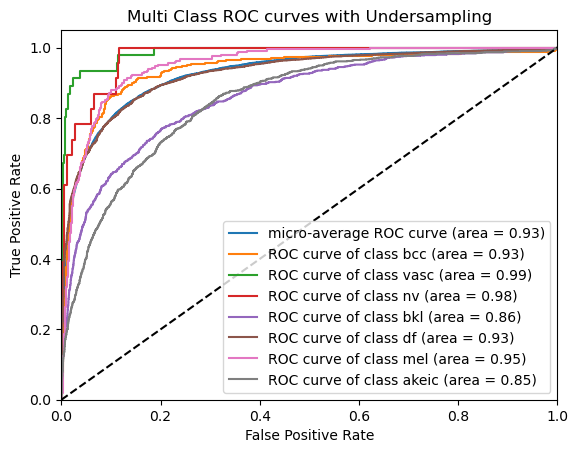

In [17]:
import matplotlib.pyplot as plt

y_test = list(results.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(results.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])

n_classes = y_test.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


class_dict = {0:'bcc', 1:'vasc', 2: 'nv', 3: 'bkl', 4: 'df', 5: 'mel', 6: 'akeic'}

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC curves with Undersampling')
plt.legend(loc="lower right")
plt.show()